# item 1 - Get data

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

%matplotlib inline

import numpy as np
import os, sys
import imageio
import pandas as pd
import matplotlib.pyplot as plt


TRAIN_DIR = os.path.join('dataset', 'train')


def get_train_img(path):
    return imageio.imread(os.path.join(TRAIN_DIR, path))


def get_patch(img, x_min, x_max, y_min, y_max):
    return img[y_min:y_max, x_min:x_max]


path_txt = os.path.join('dataset', 'train', 'gt')
path_mask = os.path.join('dataset', 'train', 'mask')

dirs_txt = os.listdir(path_txt)
dirs_mask = os.listdir(path_mask)

data = dict()

for gt in dirs_txt:
    with open(os.path.join(path_txt, gt)) as f:
        lines = f.readlines()
        
        im_name = gt.replace('gt', 'mask').replace('txt', 'png')
        im_open = (imageio.imread(os.path.join(path_mask, im_name)))

        lista = list()
        for l in lines:
            tly, tlx, bry, brx, tipo = l.split(' ')  
            tly, tlx, bry, brx = map(float, [tly, tlx, bry, brx])
            d = dict()
            d['type'] = tipo.strip()
            
            w = brx - tlx
            h = bry - tly
            
            d['width'] = w
            d['height'] = h
            d['bbox_area'] = w*h
            d['form_factor'] = w/h
            
            d['tly'] = round(tly)
            d['tlx'] = round(tlx)
            d['bry'] = round(bry)
            d['brx'] = round(brx)
            
            sub_mask = im_open[d['tly']:d['bry'], d['tlx']:d['brx']]
            mask_area = np.count_nonzero(sub_mask)
            d['mask_area'] = mask_area
            d['filling_ratio'] = mask_area / d['bbox_area']
            
            lista.append(d)
            
        data[gt] = lista
    

A    103
B     14
C     47
D     71
E     38
F    120
Name: type, dtype: int64


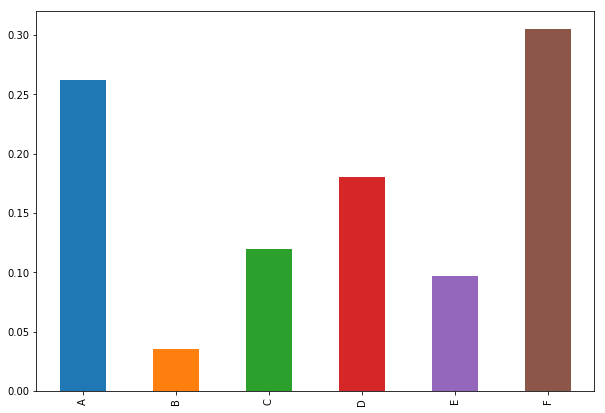

In [2]:
# Write table
columns = ['type','width','height','form_factor','bbox_area','mask_area','filling_ratio']
df = pd.DataFrame.from_dict({(i,n): data[i][n]
                        for i in data.keys()
                        for n,v in enumerate(data[i])}, columns=columns, orient='index').sort_values(['type'])
#print(df)
#df['form_factor'].plot(figsize=(10, 7))

# Count signals
n_signals = df['type'].value_counts(sort=False).reindex(['A','B','C','D','E','F'])
print(n_signals)

df['type'].value_counts(sort=False,normalize=True).reindex(['A','B','C','D','E','F']).plot(figsize=(10, 7),kind='bar',sort_columns=True)




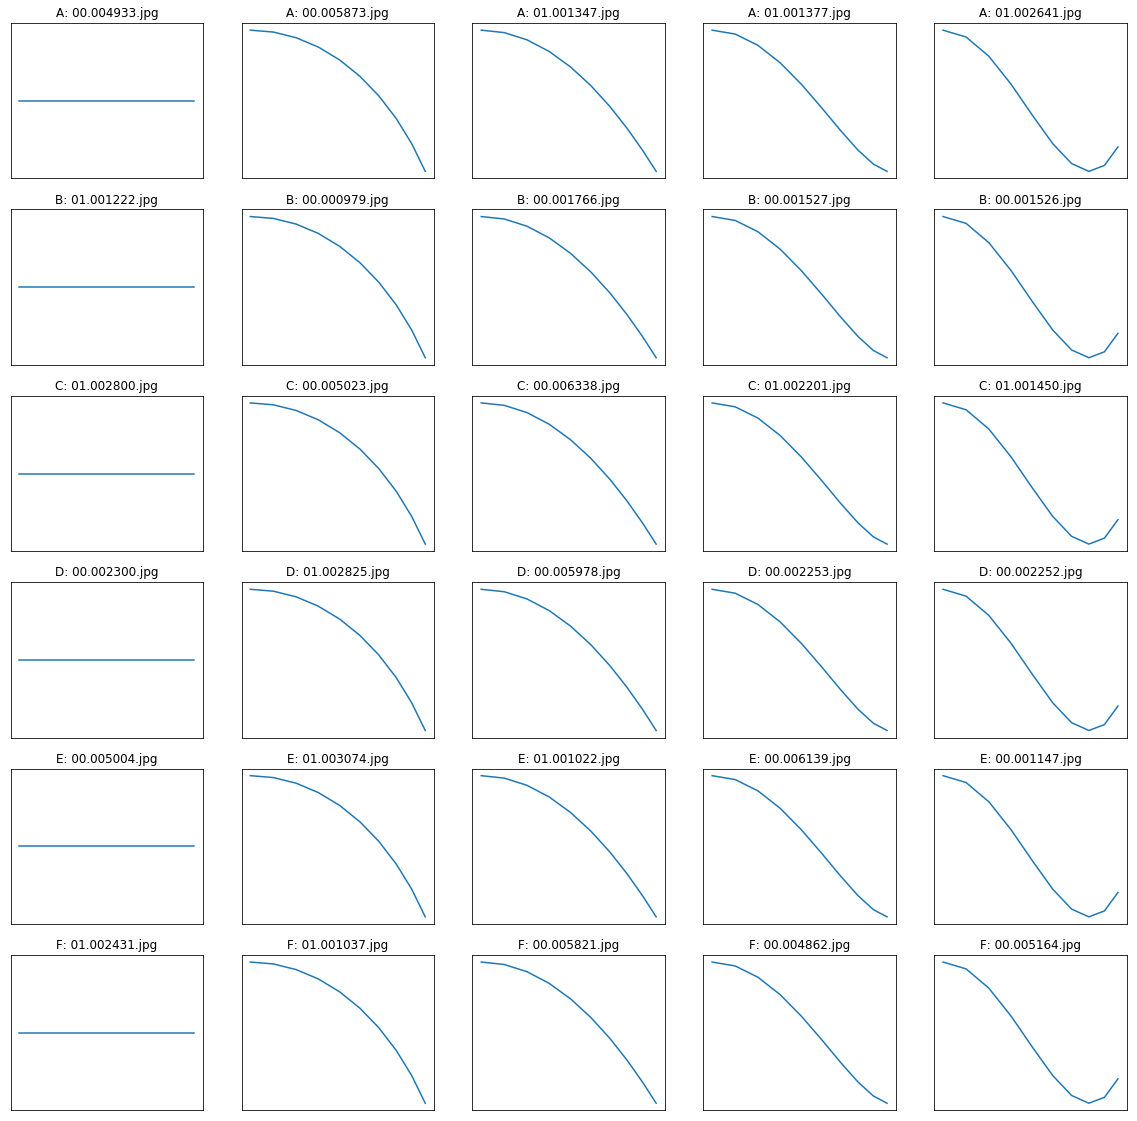

In [47]:
# Small captions of each type

import random 


def gt_to_train(gt_filename):
    return gt_filename.replace('gt.', '').replace('txt', 'jpg')


def get_unique_values_of_col(df, col):
    return np.unique(df[col].tolist())


def get_n_samples_of_col(df, col, n, val=None):
    if val is None:
        res = df[col]
    else:
        res = df[df[col] == val][col]
        
    idxs = random.sample(res.index.tolist(), n)
    
    return [v[0] for v in idxs]
    
    
plt.figure(figsize=(20, 20))
n_img = 5
types = get_unique_values_of_col(df, 'type')
l_types = len(types)

for t_idx, t in enumerate(types):
    samples_gt = get_n_samples_of_col(df, 'type', n_img, t)
    for gt_idx, gt in enumerate(samples_gt):
        train_name = gt_to_train(gt)
        plt.subplot(l_types, n_img, gt_idx + 1 + t_idx*n_img)
        plt.xticks([])
        plt.yticks([])
        plt.title('{type}: {filename}'.format(type=t, filename=train_name))
        x = np.linspace(0, 1, 10)
        plt.plot(np.sin(x), np.cos(gt_idx*x))


In [40]:
get_n_samples_of_col(df, 'type', 5, 'A')

['gt.01.001355.txt',
 'gt.00.005265.txt',
 'gt.01.001777.txt',
 'gt.01.001376.txt',
 'gt.01.001345.txt']

In [5]:
type_counts = df.groupby('type').aggregate(np.std).round(2)
type_counts

#type_counts = df.groupby('type').aggregate(np.median)
#type_counts = df.groupby('type').aggregate(np.average)
#type_counts = df.groupby('type').aggregate(np.std)


,width,height,form_factor,bbox_area,mask_area,filling_ratio
type,,,,,,
A,41.34,38.01,0.07,8279.86,4143.27,0.00
B,23.77,30.35,0.15,4742.37,2355.83,0.00
C,46.25,43.71,0.11,11043.92,8649.41,0.00
D,34.47,32.73,0.08,6220.39,5094.72,0.05
E,38.36,42.53,0.10,9622.29,7538.82,0.00
F,40.54,39.20,0.18,9245.58,9209.60,0.01


In [6]:
# Group data by "type" (letter) and get statistics:

# Function = get_stats (only shape, aspect ratio, etc, NOT COLOUR)

# Queremos estadisticas de tamaño y forma en función de cada letra        

In [7]:
# Plot and compare results

# Item 2 - Split training dataset

Al separar por tipo, tenemos que armar un algoritmo que nos separe el set de training en dos carpetas, 
separando mismos tipos en 70% / 30%.

In [8]:
# Choose randomly the 70% of each class
n_signals

A    103
B     14
C     47
D     71
E     38
F    120
Name: type, dtype: int64

In [9]:
# Get only one class
df_filtered = df[df['type'] == "B"]
df_filtered

,,type,width,height,form_factor,bbox_area,mask_area,filling_ratio
gt.01.001223.txt,0,B,57.14,48.18,1.185969,2753.0052,1372,0.498364
gt.01.001222.txt,0,B,52.52,44.96,1.168149,2361.2992,1157,0.489984
gt.01.003462.txt,0,B,106.70,96.34,1.107536,10279.4780,5093,0.495453
gt.00.001768.txt,0,B,80.61,87.42,0.922100,7046.9262,3482,0.494116
gt.00.001766.txt,0,B,120.82,121.22,0.996700,14645.8004,7220,0.492974
gt.00.004563.txt,0,B,64.70,62.74,1.031240,4059.2780,2009,0.494916
gt.00.004564.txt,0,B,62.26,57.36,1.085425,3571.2336,1767,0.494787
gt.00.004565.txt,0,B,70.10,68.38,1.025154,4793.4380,2345,0.489210
gt.00.000978.txt,0,B,90.09,78.75,1.144000,7094.5875,3505,0.494039
gt.00.000977.txt,0,B,69.94,62.47,1.119577,4369.1518,2156,0.493460


In [10]:
df_sorted_train = df_filtered.sample(frac=0.3)
df_sorted_train

,,type,width,height,form_factor,bbox_area,mask_area,filling_ratio
gt.00.000977.txt,0,B,69.94,62.47,1.119577,4369.1518,2156,0.493460
gt.00.001766.txt,0,B,120.82,121.22,0.996700,14645.8004,7220,0.492974
gt.00.000979.txt,0,B,111.84,99.60,1.122892,11139.2640,5469,0.490966
gt.00.001528.txt,0,B,72.41,96.46,0.750674,6984.6686,3456,0.494798


In [11]:
tuple(zip(df_sorted_train.index.get_level_values(0).tolist(),df_sorted_train.index.get_level_values(1).tolist()))


(('gt.00.000977.txt', 0),
 ('gt.00.001766.txt', 0),
 ('gt.00.000979.txt', 0),
 ('gt.00.001528.txt', 0))

In [12]:
df_sorted_test = pd.concat([df_filtered,df_sorted_train]).drop_duplicates(keep=False)

In [13]:
tuple(zip(df_sorted_test.index.get_level_values(0).tolist(),df_sorted_test.index.get_level_values(1).tolist()))


(('gt.01.001223.txt', 0),
 ('gt.01.001222.txt', 0),
 ('gt.01.003462.txt', 0),
 ('gt.00.001768.txt', 0),
 ('gt.00.004563.txt', 0),
 ('gt.00.004564.txt', 0),
 ('gt.00.004565.txt', 0),
 ('gt.00.000978.txt', 0),
 ('gt.00.001526.txt', 0),
 ('gt.00.001527.txt', 0))

In [14]:
# TODO Escribir funcion que saque toda la lista


# Item 3 - Separation by colour


Para cada imagen de prueba, nos basamos en el diccionario y usamos el bounding box que ya calculamos.

Recortamos la imagen, le calculamos el histograma. Sumamos los histogramas de todas las imágenes y obtenemos la suma total.

Luego hacemos lo mismo y al recortar la roi de cada imagen convertimos la roi de rgb a hsv, calculamos el histograma
y obtenemos la suma de todos los histogramas. 

Con estas cosas deberíamos poder obtener los thresholds a aplicar luego.


Hacer gráficos chetos de los histogramas. Ajustar con multiples gaussianas, calcular promedio, mediana, std, etc.
Compararlos y elegir el mejor.

Luego aplicar las máscaras con los thresholds calculados

In [15]:
# Convert RGB images tu HUE images

# Get stats from HUE images

# Plot and compare

# Select thresholds (RGB y HUE)

# Create masks using previous thresholds



# Calculate histograms:

In [16]:
from skimage import color

path_jpg = os.path.join('dataset', 'train', 'jpg')
dirs_jpg = os.listdir(path_jpg)

def rgb_histogram(gt_dictionary, path_jpg):

    r_hist = np.zeros(255)
    g_hist = np.zeros(255)
    b_hist = np.zeros(255)

    for gt, values in list(gt_dictionary.items()):
        for v in values:

            jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
            jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]

            bins = np.histogram(jpg_roi[:,:,0], bins=255, range=(1,255))[1]
            r_hist += np.histogram(jpg_roi[:,:,0], bins=255, range=(1,255))[0]
            g_hist += np.histogram(jpg_roi[:,:,1], bins=255, range=(1,255))[0]
            b_hist += np.histogram(jpg_roi[:,:,2], bins=255, range=(1,255))[0]
    
    return bins, r_hist, g_hist, b_hist


def hsv_histogram(gt_dictionary, path_jpg):

    h_hist = np.zeros(255)
    s_hist = np.zeros(255)
    v_hist = np.zeros(255)

    for gt, values in list(gt_dictionary.items()):
        for v in values:

            jpg_name = gt.replace('gt.', '').replace('txt', 'jpg')
            jpg_roi = imageio.imread(os.path.join(path_jpg, jpg_name))[v['tly']:v['bry'], v['tlx']:v['brx']]
            hsv_roi = color.rgb2hsv(jpg_roi)*255
            
            bins = np.histogram(hsv_roi[:,:,0], bins=255, range=(1,255))[1]
            h_hist += np.histogram(hsv_roi[:,:,0], bins=255, range=(1,255))[0]
            s_hist += np.histogram(hsv_roi[:,:,1], bins=255, range=(1,255))[0]
            v_hist += np.histogram(hsv_roi[:,:,2], bins=255, range=(1,255))[0]
    
    return bins, h_hist, s_hist, v_hist

################################################
# Calculate histograms with traffic signal data:
################################################

# RGB histograms:

bins, r_hist, g_hist, b_hist = rgb_histogram(data, path_jpg)

# HSV histograms:

hbins, h_hist, s_hist, v_hist = hsv_histogram(data, path_jpg)


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/train/jpg'

# Plot histograms:

In [ ]:
# Questions: why can't I use the variable 'bins' to plot the histograms?
# Why do I get a divergence at 255?
# Why am I dividing by zero when converting to HSV?

def plot_histogram(hist, color_name, color_plot):

    x = np.arange(255)

    plt.figure(figsize=(7,7))
    plt.bar(x, hist, color=color_plot)
    plt.ylim((0,60000))
    plt.title(color_name + ' histogram')
    plt.xlabel('8bit quantification')
    plt.ylabel('Total number of px')
    plt.show()
    
# Plot RGB histograms:

plot_histogram(r_hist, 'Red', 'r')
plot_histogram(g_hist, 'Green', 'g')
plot_histogram(b_hist, 'Blue', 'b')

# Plot HSV histograms:

plot_histogram(h_hist, 'H', 'r')
plot_histogram(s_hist, 'S', 'g')
plot_histogram(v_hist, 'V', 'b')


# Item 4 - Evaluate colour masks 

Comparar las máscaras obtenidas con el ground truth.

Podemos ver si sirven las funciones que ya nos dieron hechas.

# Lo que sigue a partir de aqui fueron pruebas hechas el martes:

In [ ]:
print(data['gt.00.005025.txt'][0])
print(data['gt.00.005025.txt'][1])

for gt in dirs_txt:
    print(data[gt][0]['filling_ratio'])

In [ ]:
for mask in dirs_mask:
    gt = mask.replace('mask', 'gt').replace('png', 'txt')
    m = (imageio.imread(os.path.join(path_mask, mask)))
    mask_area = m.sum()
    d = data[gt]
    d['mask_area'] = mask_area
    d['filling_ratio'] = mask_area / d['bbox_area']
    
    print(d['mask_area'], d['filling_ratio'], mask)
    

In [ ]:
print(dirs_mask[0].replace('mask', 'gt').replace('png', 'txt'))
print(dirs_txt[0])


In [ ]:
import matplotlib.pyplot as plt

% matplotlib inline

m = imageio.imread(os.path.join(path_mask,'mask.00.005025.png')).astype(np.int8)

plt.imshow(m[146:201, 1324:1375])
